<a href="https://colab.research.google.com/github/DrZee24/DFNN/blob/main/DFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time
import random
np.set_printoptions(suppress=True)

# Constants
M = 320  # Number of samples
D = 3  # Number of dimensions (including time)
L = 9  # Layers (depth)
N = 20  # Nodes per layer (width)
learning_rate = 5e-4
epochs = 100
m = 64  # Mini-batch size
reg = 1e-5  # L^2 regularization
beta = 0.9  # Constant of momentum
epsilon = 0.1  # Step size of finite difference
r = 0.05  # Interest rate
K = 3.0  # Strike price
sigma = 0.15  # Volatility

# Initializations
X = 7.0 * np.random.random_sample((M, D))  # Data (input)

# Boundary conditions
X[:, 0] = 10 * np.random.random_sample(M)
X[0:10, 0] = 0.0
X[10:20, 0] = 10.0
X[20:30, 1] = 0.0
X[30:40, 1] = 7.0
X[40:50, 2] = 0.0
X[50:60, 2] = 7
print(X.shape)
print(X)

(320, 3)
[[ 0.          6.07861147  5.32500353]
 [ 0.          2.89116601  0.28370075]
 [ 0.          4.129814    6.17068044]
 [ 0.          4.57653873  1.19123688]
 [ 0.          1.01726061  4.66168749]
 [ 0.          2.83468915  4.52759282]
 [ 0.          4.2114285   1.41409838]
 [ 0.          2.94191675  2.78151025]
 [ 0.          4.43634203  6.40222685]
 [ 0.          0.39396459  4.91786869]
 [10.          0.27324945  0.7333597 ]
 [10.          5.35345723  6.02894532]
 [10.          1.1739736   5.28984575]
 [10.          6.63562373  3.33492932]
 [10.          3.91378842  0.67176474]
 [10.          0.94835601  5.5113527 ]
 [10.          4.79600834  5.84375474]
 [10.          0.45767257  5.63835524]
 [10.          3.27653265  0.06962032]
 [10.          6.32530928  6.57185782]
 [ 2.64137902  0.          2.71396494]
 [ 5.35409141  0.          0.64483975]
 [ 4.42736812  0.          5.57068768]
 [ 8.04088321  0.          6.58904309]
 [ 6.67099     0.          4.38251218]
 [ 6.11713295  0

In [2]:
W_in = np.random.randn(D, N) * np.sqrt(2.0 / D)  # Weights layer 1
b_in = np.ones((1, N)) * 0.01  # Bias layer 1

W = np.random.randn(L - 1, N, N) * np.sqrt(2.0 / N)  # Weights layers
b = np.ones((L - 1, 1, N)) * 0.01  # Biases

W_out = np.random.randn(N, 1) * np.sqrt(2.0 / N)  # Weights output layer
b_out = 0.01  # Bias output layer

hidden_layers = np.zeros((L, M, N))

dW_in = np.zeros((D, N))
dW = np.zeros((L-1, N,N))
dW_out= np.zeros((N, 1))

db_in = np.zeros((D, N))
db = np.zeros((L-1, N,N))
db_out= np.zeros((N, 1))

VdW_in = np.zeros((D, N))  # Momentum for weights layer 1
VdW = np.zeros((L - 1, N, N))  # Momentum for weights layers
VdW_out = np.zeros((N, 1))  # Momentum for weights output layer

Vdb_in = np.zeros((1, N))  # Momentum for bias layer 1
Vdb = np.zeros((L - 1, 1, N))  # Momentum for biases layers
Vdb_out = 0.0  # Momentum for bias output layer
print (W_in)

[[-0.56930253  2.01319935  0.88631678  0.06986006 -1.15458966 -0.20311274
   0.15318781 -0.03768812  0.27250712 -0.33436499 -0.16151038  0.85435939
  -1.83929679 -0.79628047 -1.028104   -0.66081487 -0.04927136  0.21700766
   0.52954385 -0.11409929]
 [ 1.77310022 -1.37143195 -1.02746886  1.59065421  0.80118933 -0.49296803
  -1.11282537  1.16569222  0.66361853 -0.30138472 -0.79226358 -0.6040003
   1.02353802  0.79842289 -0.38541352 -0.63504152 -0.90077562 -0.44666659
  -0.83800978 -0.57256362]
 [ 1.57375563 -1.02516884  0.13232002  0.3032842   0.74940912 -0.31846222
   1.87135388 -0.61946602  0.84211333 -0.40725244  1.06692683  0.00024913
  -0.00130889 -1.3587853  -0.21033945  0.81314434 -1.10071875  0.70008949
   0.97240491 -0.51580518]]


Fonction d activisation: ReLU (Rectified Linear Unit)

In [3]:
def relu(x):
    """Rectified Linear Unit (ReLU)"""
    return np.maximum(0, x)

la propagation en avant dans un réseau de neurones. Cette fonction calcule les sorties des neurones à chaque couche du réseau en appliquant les poids et les biais, ainsi que la fonction d'activation ReLU aux couches cachées, pour produire la sortie finale du réseau.

In [4]:
def forward_pass(hidden_layers, X, W_in, W, W_out, b_in, b, b_out):
    """Forward pass of neural network"""
    L, M, N = hidden_layers.shape
    hl = np.copy(hidden_layers)

    # Layer 1
    hl[0, :, :] = np.dot(X, W_in) + b_in
    hl[0, :, :] = relu(hl[0, :, :])

    # Hidden layers
    for j in range(1, L):
        hl[j, :, :] = np.dot(hl[j - 1, :, :], W[j - 1, :, :]) + b[j - 1, :, :]
        hl[j, :, :] = relu(hl[j, :, :])

    # Output layer
    output = np.dot(hl[L - 1, :, :], W_out) + b_out

    return output, hl

loss function for training model  la perte quadratique moyenne (MSE):
  Simplicité : La MSE est simple à calculer et interpréter.
  Continuité : La MSE est une fonction continue, ce qui facilite l'optimisation.
  Sensibilité aux grandes erreurs : La MSE donne plus de poids aux grandes erreurs en raison de la mise au carré des différences, ce qui peut être un avantage ou un inconvénient selon le problème.

In [5]:
def loss_function(out, dout, ddout, X=X, M=M):
    """Loss function"""
    t = np.copy(X[:, 0]).reshape(M, 1)
    expectation = np.zeros_like(out)

    for _ in range(100):
        dt = (10 - t) / 100
        x = np.copy(X[:, 1:D]).reshape(M, D - 1)

        for n in range(100):
            x = x + x * r * dt + sigma * np.sqrt(dt) * x * np.random.randn(M, D - 1)

        I = -r * (10 - t)
        psi = np.mean(np.maximum(0, x - K), axis=1).reshape(M, 1)
        expectation += np.exp(I) * psi

    expectation /= 100.0
    loss = np.mean((out - expectation) ** 2)
    d_loss = 2 * (out - expectation) / M

    return loss, d_loss

Rétropropagation (backward pass) : Cette étape consiste à calculer les gradients des poids et des biais par rapport à la perte. La rétropropagation permet de savoir comment les paramètres du réseau (poids et biais) doivent être ajustés pour réduire la perte.
 mini-batch gradient descent

In [6]:
def sgd(step_size, hidden_layers, W_in, W, W_out, b_in, b, b_out, dW_in, dW, dW_out, db_in, db, db_out, VdW_in, VdW, VdW_out, Vdb_in, Vdb, Vdb_out):

# Créer une liste d'indices et les mélanger
    mini_batches = []
    np.random.shuffle(list(range(M)))
    hl = np.copy(hidden_layers)
    X_shuffled = X[list(range(M))]
    hl_shuffled = hl[:, list(range(M)), :]


# Créer les mini-batches
    for k in range(0, M, m):
    # Sélectionner les indices pour le mini-batch
         indices = list(range(M))[k:k + m]

    # Créer les mini-batches pour X et hl
         X_batch = X_shuffled[indices]
         hl_batch = hl_shuffled[:, indices]

    # Ajouter le mini-batch à la liste
         mini_batches.append((X_batch, hl_batch))

# Traiter chaque mini-batch
    for X_batch, hl_batch in mini_batches:
    # Forward pass
     out_batch, hl_batch = forward_pass(hl_batch, X_batch, W_in, W, W_out, b_in, b, b_out)

    # Initialiser dout_batch et ddout_batch
     dout_batch, ddout_batch = 0.0, 0.0

    # Calcul de la perte et des gradients
    loss_batch, dLoss_batch = loss_function(out_batch, dout_batch, ddout_batch, X=X_batch, M=m)

    # Normaliser la perte
    dLoss_batch /= m

    # Calcul des gradients et mise à jour des paramètres
    dW_out = np.dot(hl_batch[L-1].T, dLoss_batch)
    db_out = np.sum(dLoss_batch, axis=0, keepdims=False)
    dhidden = np.dot(dLoss_batch, W_out.T)
    dhidden[hl_batch[L-1] <= 0] = 0

    # Initialiser dW et db
    dW = np.zeros((L - 1, N, N))
    db = np.zeros((L - 1, 1, N))

    # Backpropagation
    for j in reversed(range(0, L - 1)):
        dW[j] = np.dot(hl_batch[j].T, dhidden)
        db[j] = np.sum(dhidden, axis=0, keepdims=False)
        dhidden = np.dot(dhidden, W[j].T)
        dhidden[hl_batch[j] <= 0] = 0

    dW_in = np.dot(X_batch.T, dhidden)
    db_in = np.sum(dhidden, axis=0)

    # Appliquer la régularisation L2
    dW_in += reg * W_in
    dW += reg * W
    dW_out += reg * W_out


    VdW_in = beta * VdW_in - step_size * dW_in
    VdW = beta * VdW - step_size * dW
    VdW_out = beta * VdW_out - step_size * dW_out

    Vdb_in = beta * Vdb_in - step_size * db_in
    Vdb = beta * Vdb - step_size * db
    Vdb_out = beta * Vdb_out - step_size * db_out

    # Update parameters
    W_in += VdW_in
    W += VdW
    W_out += VdW_out

    b_in += Vdb_in
    b += Vdb
    b_out += Vdb_out

La fonction derivative calcule les dérivées premières (et optionnellement, secondes) d'un réseau de neurones en utilisant des différences finies par rapport aux entrées du réseau de neurones (X).

In [7]:
def derivative(hidden_layers, X=X, order='first'):
    """Finite differences of neural network"""
    h = epsilon
    u = forward_pass(hidden_layers, X, W_in, W, W_out, b_in, b, b_out)[0]

    h1 = np.zeros_like(X)
    h1[:, 0] += h
    h2 = np.zeros_like(X)
    h2[:, 1] += h

    u1p = forward_pass(hidden_layers, X + h1, W_in, W, W_out, b_in, b, b_out)[0]
    u1m = forward_pass(hidden_layers, X - h1, W_in, W, W_out, b_in, b, b_out)[0]
    du1 = (u1p - u1m) / (2 * h)

    u2p = forward_pass(hidden_layers, X + h2, W_in, W, W_out, b_in, b, b_out)[0]
    u2m = forward_pass(hidden_layers, X - h2, W_in, W, W_out, b_in, b, b_out)[0]
    du2 = (u2p - u2m) / (2 * h)

    if order == 'second':
        ddu1 = (u1p - 2 * u + u1m) / h ** 2
        ddu2 = (u2p - 2 * u + u2m) / h ** 2
    else:
        ddu1, ddu2 = np.zeros_like(u), np.zeros_like(u)

    return [du1, du2], [ddu1, ddu2]

In [8]:
def test(hidden_layers):
    """Find loss of NN on random validation set"""
    test_points = 7.0 * np.random.random_sample((M, D))
    test_points[:, 0] = 10 * np.random.random_sample(M)

    u, _ = forward_pass(hidden_layers, test_points,W_in, W, W_out, b_in, b, b_out)
    du = ddu = 0.0

    return np.sum(loss_function(u, du, ddu, X=test_points)[0]) / M

def learning_rate_schedule(loss, learning_rate):
    """Learning rate schedule to reduce learning rate during training."""
    # Plan linéaire de réduction du taux d'apprentissage
    initial_lr = learning_rate
    final_lr = learning_rate / 10  # Réduire le taux d'apprentissage final de 10x
    max_epochs= 100
    # Calculer le taux d'apprentissage ajusté selon l'époque
    step_size = initial_lr - (epochs / max_epochs) * (initial_lr - final_lr)

    # Retourner le taux d'apprentissage ajusté
    return step_size


In [9]:
# Main part
test_array = np.zeros(epochs)  # To plot loss
loss_array = np.zeros(epochs)  # To plot loss
 # Pour la technique de `early stopping` (arrêt anticipé)
best_val_loss = float('inf')
patience = 5  # Nombre d'époques à attendre avant d'arrêter si pas d'amélioration
patience_counter = 0
loss = 1.0
i = 0
step_size = learning_rate_schedule(loss, learning_rate)
print(step_size)
while loss >= 0.001 and i < epochs:
  try:
    out, hidden_layers =forward_pass(hidden_layers, X, W_in, W, W_out, b_in, b, b_out)
    dout, ddout = 0.0, 0.0

    # Loss calculation
    data_loss = np.sum(loss_function(out, dout, ddout)[0]) / M
    reg_loss = 0.5 * reg * np.sum(W_in * W_in) + 0.5 * reg * np.sum(W_out * W_out) + 0.5 * reg * np.sum(W * W)
    loss = data_loss + reg_loss

    # Parameter update
    sgd(step_size, hidden_layers, W_in, W, W_out, b_in, b, b_out, dW_in, dW, dW_out, db_in, db, db_out, VdW_in, VdW, VdW_out, Vdb_in, Vdb, Vdb_out)

    # Évaluation sur l'ensemble de test
    val_loss = test(hidden_layers)
    loss_array[i] = loss
    test_array[i] = val_loss

    # Continuously print loss
    if i % 10 == 0:
        print(f"Loss at epoch {i} = {loss}, data loss: {data_loss}")
    # Vérifier si la perte de validation s'est améliorée
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Réinitialiser le compteur de patience
    else:
       patience_counter += 1

    i += 1
    step_size = learning_rate_schedule(loss, learning_rate)
  except Exception as e:
            print(f"An error occurred during training: {e}")
            break
print(f"Loss at end = {loss}")
print(out)
print(f"Test loss: {test(hidden_layers)}")

5.000000000000002e-05
Loss at epoch 0 = 0.01410710238225012, data loss: 0.012283124251397232
Loss at epoch 10 = 0.014224374731748247, data loss: 0.012400397779753125
Loss at epoch 20 = 0.013859554258976869, data loss: 0.012035578457738269
Loss at epoch 30 = 0.013918727242685388, data loss: 0.012094752583130688
Loss at epoch 40 = 0.013808051914348748, data loss: 0.011984078374326145
Loss at epoch 50 = 0.013689891600592379, data loss: 0.011865919166934897
Loss at epoch 60 = 0.01372893713228007, data loss: 0.011904965790955398
Loss at epoch 70 = 0.013665921086086693, data loss: 0.011841950817183176
Loss at epoch 80 = 0.013628133150011948, data loss: 0.011804163930849647
Loss at epoch 90 = 0.013477858359127041, data loss: 0.011653890171032515
Loss at end = 0.01346623794730032
[[ 5.36375638]
 [ 1.93824183]
 [ 2.63648692]
 [ 3.44803833]
 [-0.51121177]
 [ 1.64379301]
 [ 3.31040016]
 [ 2.56046314]
 [ 2.89035294]
 [-0.61263002]
 [ 0.39143112]
 [ 0.17297361]
 [-0.27298337]
 [-0.25555753]
 [ 0.15

In [11]:
def plot_loss(train_loss, val_loss):
    """Trace les pertes d'entraînement et de validation."""
    plt.figure()
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

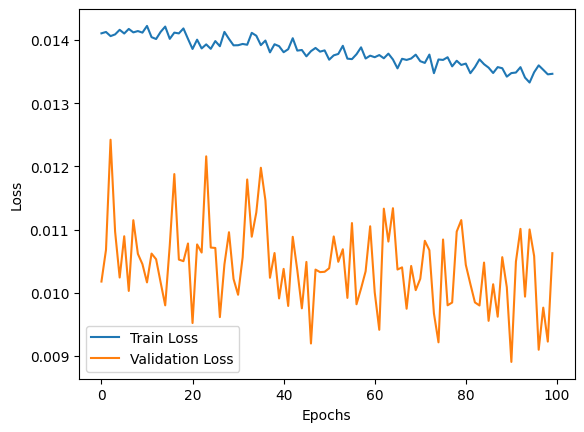

In [12]:
plot_loss(loss_array, test_array)

Time taken: 0.00 seconds


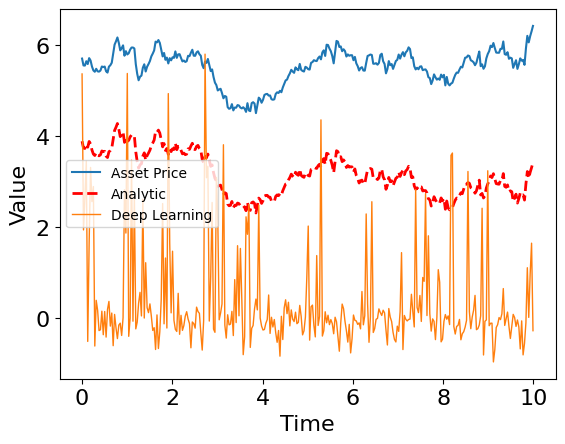

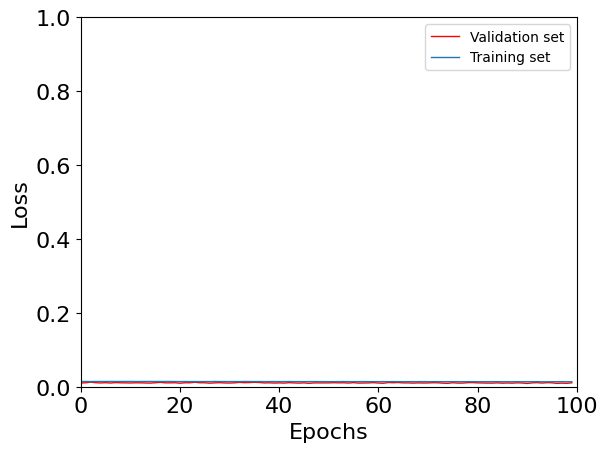

In [13]:
started = time.time()
elapsed = time.time() - started
print(f"Time taken: {elapsed:.2f} seconds")

# Plots
times = np.linspace(0, 9.99, M)
dt = times[1] - times[0]
tau = (10 - times).reshape(M, 1)



for i in range(M - 1):
    X[i + 1, 1:D] = X[i, 1:D] + X[i, 1:D] * r * dt + sigma * np.sqrt(dt) * X[i, 1:D] * np.random.randn(D - 1)
meanX = np.mean(X[:, 1:D], axis=1).reshape(M, 1)
dp = (np.log(meanX / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
dm = dp - sigma * np.sqrt(tau)

C1 = norm.cdf(dp) * meanX - norm.cdf(dm) * K * np.exp(-r * tau)
plt.plot(times, meanX, '-', label='Asset Price')
plt.plot(times, C1, 'r--', label='Analytic', lw=2)
plt.plot(times, out, '-', label='Deep Learning', lw=1)
plt.tick_params(labelsize=16)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.legend()
plt.show()

plt.plot(range(epochs), test_array, 'r-', label='Validation set', lw=1)
plt.plot(range(epochs), loss_array, '-', label='Training set', lw=1)
plt.tick_params(labelsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.axis([0, epochs, 0, 1])
plt.legend()
plt.show()

